In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

In [4]:
df = pd.read_csv("data.csv")

In [5]:
df = df.drop(columns=df.columns[-1])
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,911321486,B,11.61788,12.56323,74.63132,416.53872,0.08375,0.07435,0.04312,0.03090,...,12.59719,17.28923,81.68042,490.87245,0.09044,0.12978,0.10472,0.05883,0.22733,0.06942
1,851509,M,21.16000,23.04000,137.20000,1404.00000,0.09428,0.10220,0.10970,0.08632,...,29.17000,35.59000,188.00000,2615.00000,0.14010,0.26000,0.31550,0.20090,0.28220,0.07526
2,885429,M,19.73000,19.82000,130.70000,1206.00000,0.10620,0.18490,0.24170,0.09740,...,25.28000,25.59000,159.80000,1933.00000,0.17100,0.59550,0.84890,0.25070,0.27490,0.12970
3,911322632,B,12.30480,19.07894,78.17835,467.40880,0.09034,0.04203,0.01270,0.01334,...,13.56373,23.96950,86.53882,569.37669,0.11455,0.06037,0.02844,0.04041,0.21108,0.06639
4,911323929,M,14.71755,27.24008,97.93851,678.07193,0.10354,0.13944,0.14918,0.08369,...,19.40519,42.26036,132.46459,1138.49850,0.17635,0.47386,0.57427,0.18200,0.36688,0.10828


#Preprocessing

In [6]:
df.drop_duplicates(subset=['id'])
df.drop(['id'], axis=1, inplace=True)

df.dropna(inplace=True)

df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [7]:
print("Missing values per column:\n", df.isnull().sum(), "\n")

Missing values per column:
 diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64 



In [8]:
print("Shape after cleaning:", df.shape, "\n")
print("Summary statistics:\n", df.describe(), "\n")

Shape after cleaning: (4569, 31) 

Summary statistics:
          diagnosis  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  4569.000000  4569.000000   4569.000000     4569.000000  4569.000000   
mean      0.370322    14.153431     19.331974       92.148913   657.980471   
std       0.482944     3.529855      4.297151       24.351560   353.284326   
min       0.000000     4.712210      2.239980       27.148340   -78.262150   
25%       0.000000    11.707580     16.390000       75.192670   423.247810   
50%       0.000000    13.386080     19.220000       86.681870   555.100000   
75%       1.000000    16.030000     21.997450      104.636000   795.067050   
max       1.000000    29.103220     39.280000      194.424520  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count      4569.000000       4569.000000     4569.000000          4569.000000   
mean          0.096167          0.104381        0.088717             0.048860  

#Outliers

In [9]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
outlier_counts = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()
print("Outliers detected per column:\n", outlier_counts, "\n")

Outliers detected per column:
 diagnosis                    0
radius_mean                101
texture_mean                59
perimeter_mean             118
area_mean                  234
smoothness_mean             48
compactness_mean           136
concavity_mean             133
concave points_mean        110
symmetry_mean               85
fractal_dimension_mean     159
radius_se                  338
texture_se                  75
perimeter_se               363
area_se                    579
smoothness_se              240
compactness_se             233
concavity_se               184
concave points_se          122
symmetry_se                163
fractal_dimension_se       169
radius_worst               142
texture_worst               39
perimeter_worst            137
area_worst                 295
smoothness_worst            72
compactness_worst          160
concavity_worst             80
concave points_worst         6
symmetry_worst             177
fractal_dimension_worst    211
dtype: i

#Handel Outliers

In [10]:
selected_cols = ['area_se', 'radius_se', 'perimeter_se', 'smoothness_se', 'fractal_dimension_worst']

Q1 = df[selected_cols].quantile(0.25)
Q3 = df[selected_cols].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[~((df[selected_cols] < (Q1 - 1.5 * IQR)) |
                      (df[selected_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Shape after selective outlier removal:", df_no_outliers.shape)

Shape after selective outlier removal: (3596, 31)


In [11]:
df.head(10)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,0,11.61788,12.56323,74.63132,416.53872,0.08375,0.07435,0.04312,0.03090,0.16529,...,12.59719,17.28923,81.68042,490.87245,0.09044,0.12978,0.10472,0.05883,0.22733,0.06942
1,1,21.16000,23.04000,137.20000,1404.00000,0.09428,0.10220,0.10970,0.08632,0.17690,...,29.17000,35.59000,188.00000,2615.00000,0.14010,0.26000,0.31550,0.20090,0.28220,0.07526
2,1,19.73000,19.82000,130.70000,1206.00000,0.10620,0.18490,0.24170,0.09740,0.17330,...,25.28000,25.59000,159.80000,1933.00000,0.17100,0.59550,0.84890,0.25070,0.27490,0.12970
3,0,12.30480,19.07894,78.17835,467.40880,0.09034,0.04203,0.01270,0.01334,0.16045,...,13.56373,23.96950,86.53882,569.37669,0.11455,0.06037,0.02844,0.04041,0.21108,0.06639
4,1,14.71755,27.24008,97.93851,678.07193,0.10354,0.13944,0.14918,0.08369,0.21452,...,19.40519,42.26036,132.46459,1138.49850,0.17635,0.47386,0.57427,0.18200,0.36688,0.10828
5,1,16.25608,20.88844,106.30594,836.35665,0.09302,0.11287,0.08943,0.04918,0.17382,...,19.45185,32.71410,130.54040,1220.45993,0.13872,0.35957,0.39208,0.17121,0.36339,0.08467
6,0,9.68300,19.34000,61.05000,285.70000,0.08491,0.05030,0.02337,0.00961,0.15800,...,10.93000,25.59000,69.10000,364.20000,0.11990,0.09546,0.09350,0.03846,0.25520,0.07920
7,0,13.01313,23.35450,83.74505,501.75945,0.10001,0.09482,0.05266,0.04009,0.20756,...,14.01605,29.56027,92.11082,586.72799,0.12119,0.18596,0.14585,0.09491,0.25235,0.07887
8,0,15.17616,23.55722,96.82648,711.70519,0.08181,0.04980,-0.00079,0.01886,0.15406,...,16.53877,29.10578,105.04086,851.14253,0.09642,0.06484,-0.03436,0.05606,0.19879,0.06216
9,0,16.17885,14.82998,104.48608,777.28709,0.11226,0.09314,0.05092,0.05700,0.17996,...,17.60712,19.27192,113.05034,904.30348,0.14383,0.10924,0.02754,0.10603,0.29720,0.07359


#Visualization

#Histrograms

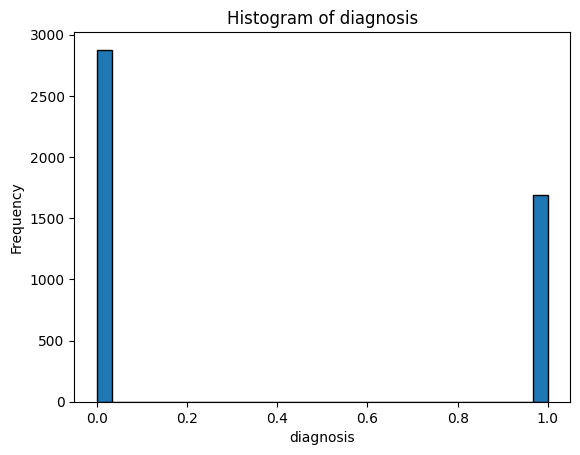

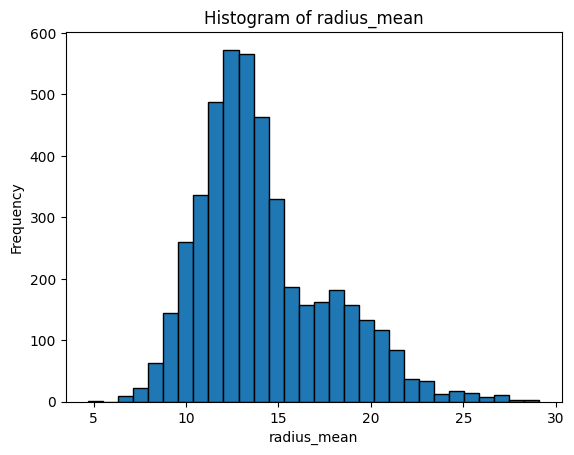

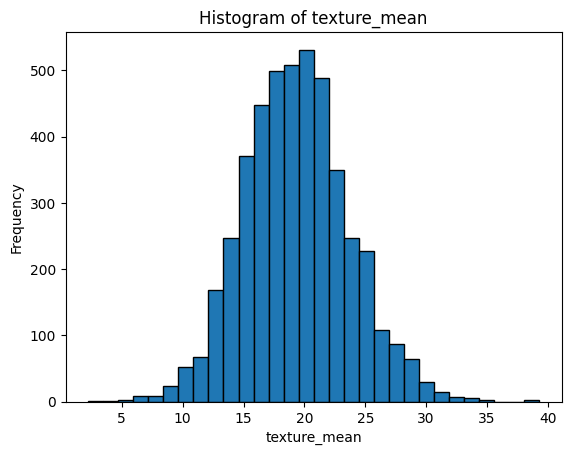

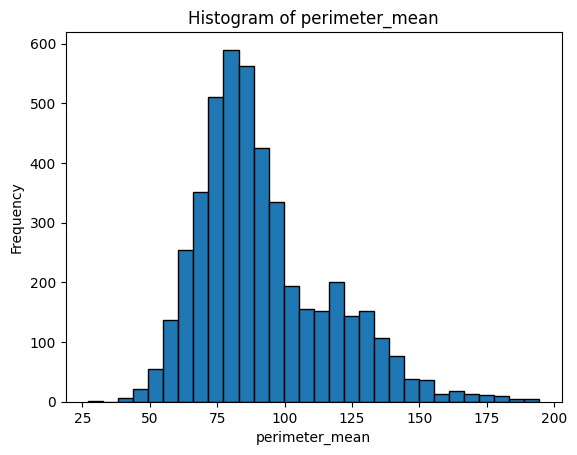

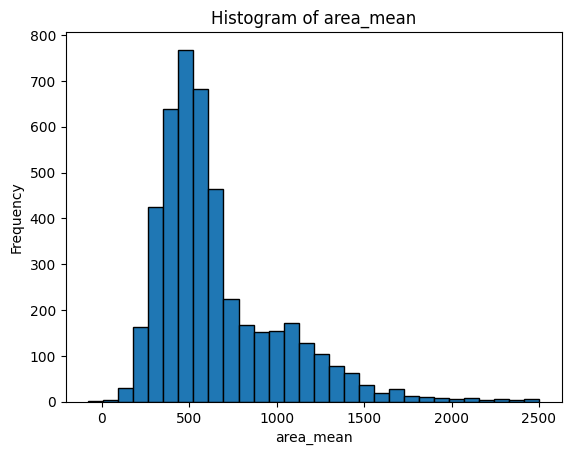

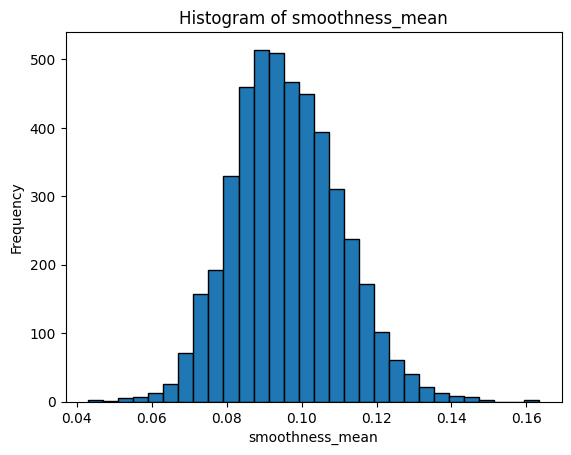

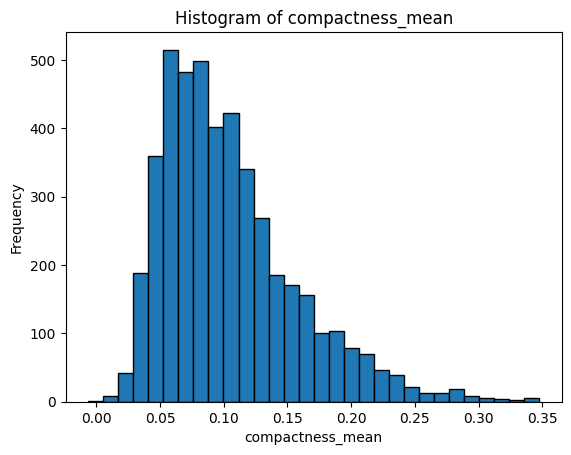

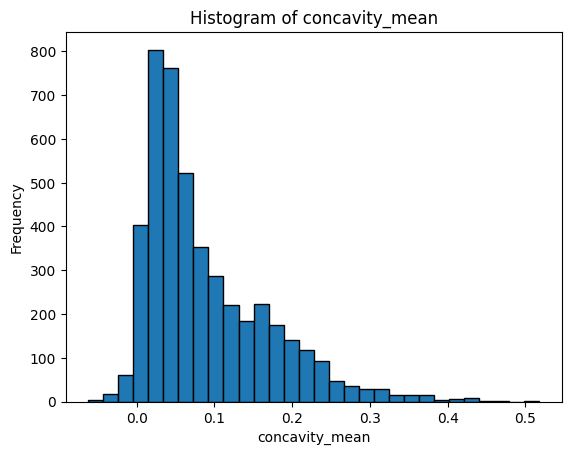

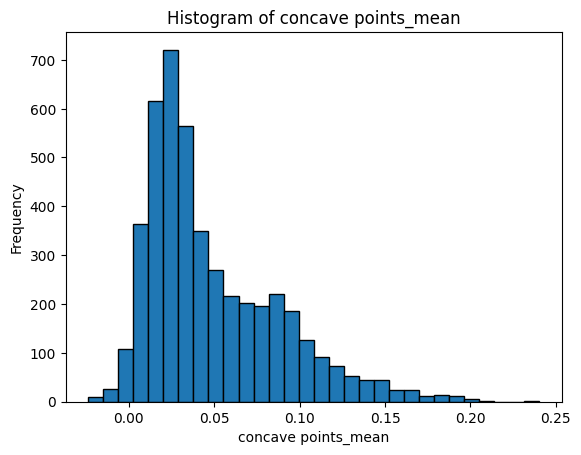

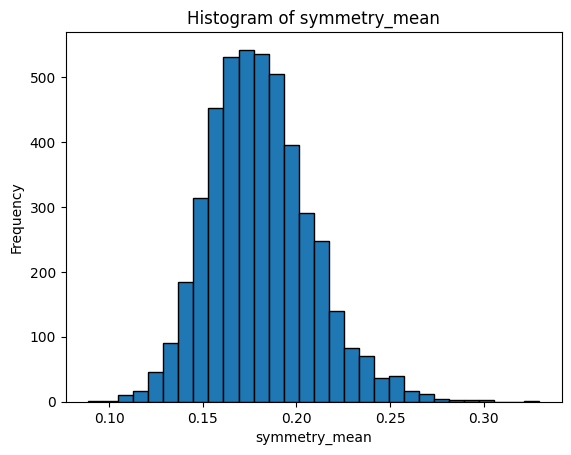

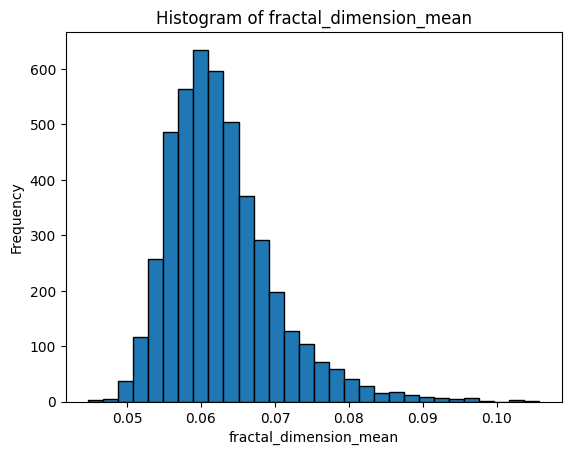

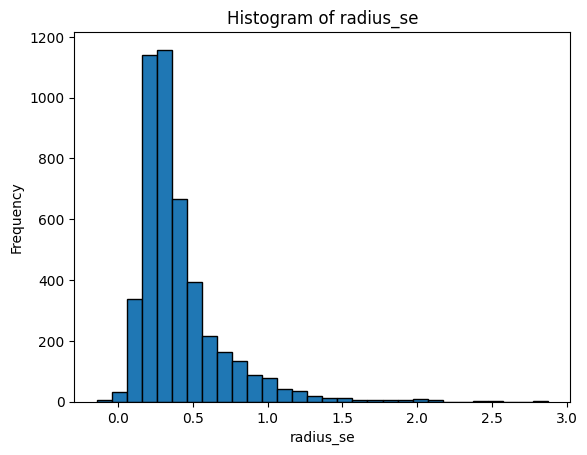

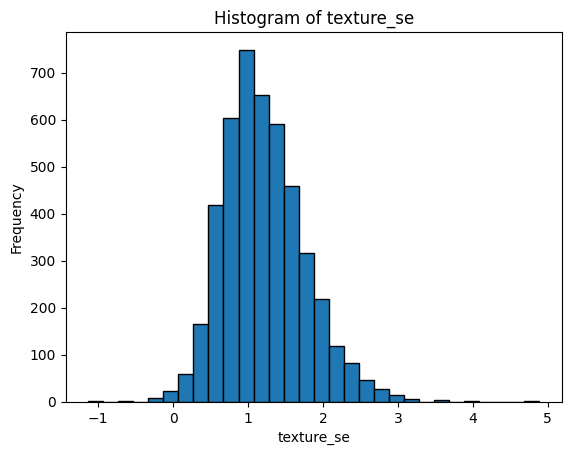

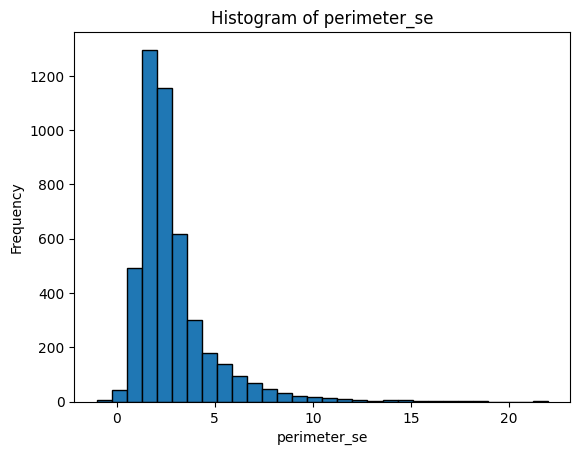

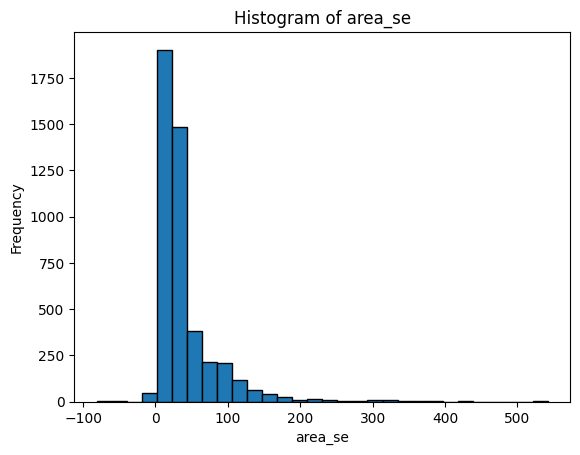

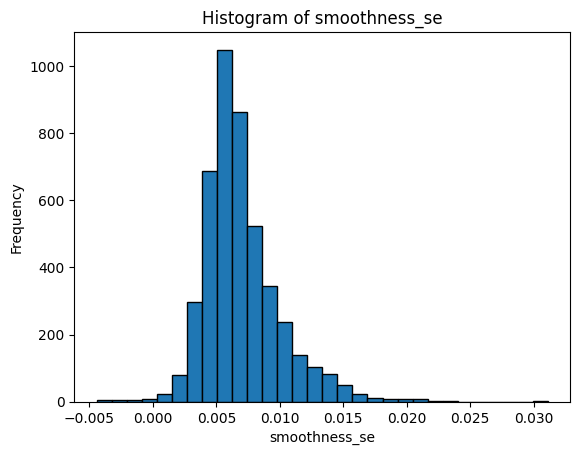

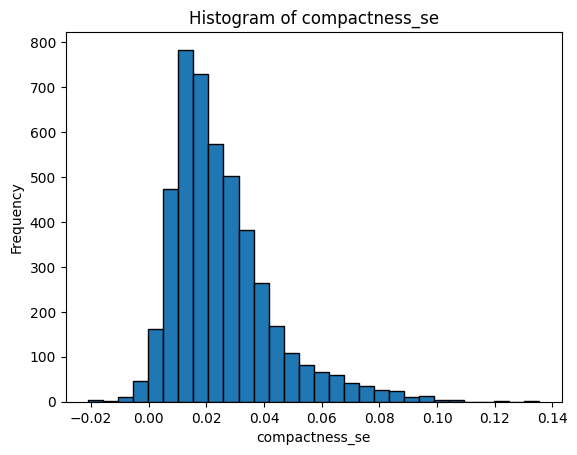

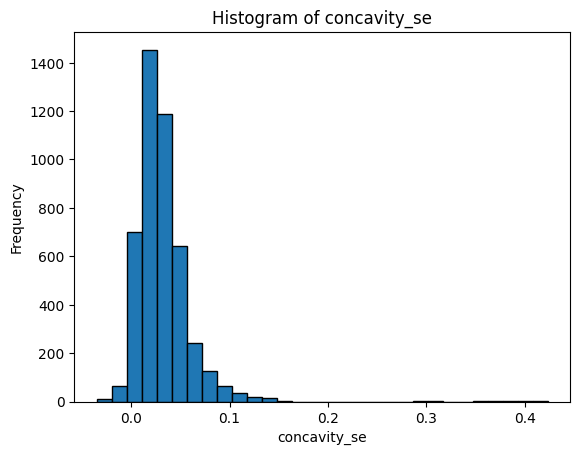

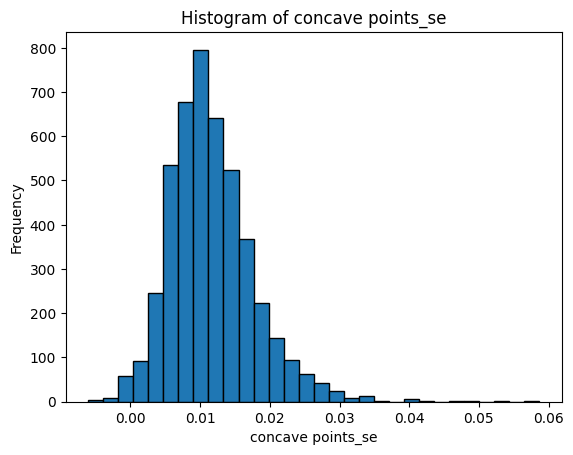

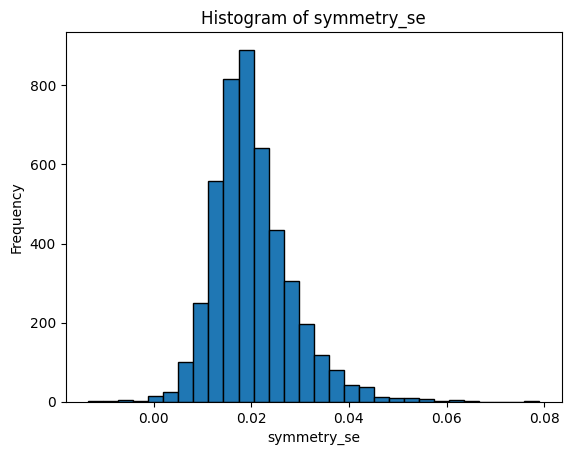

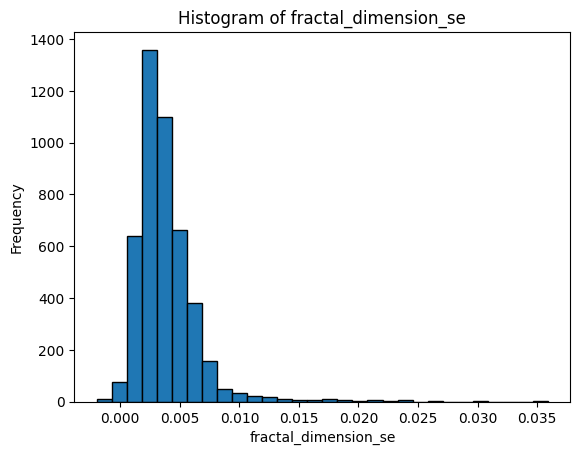

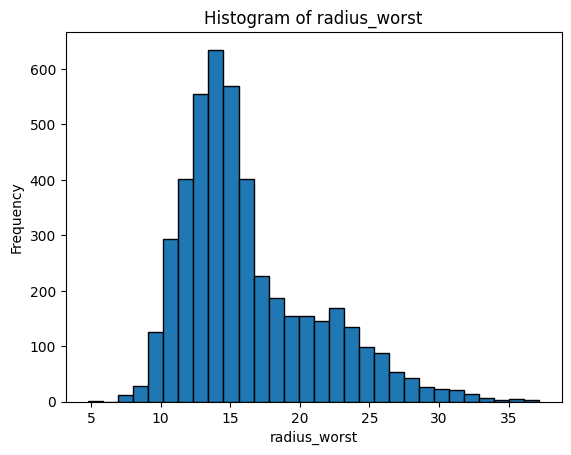

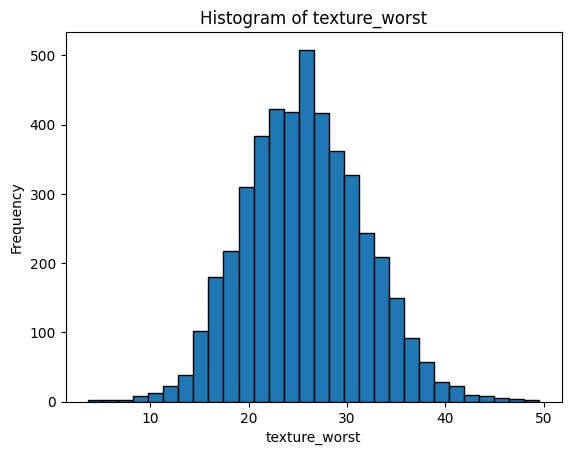

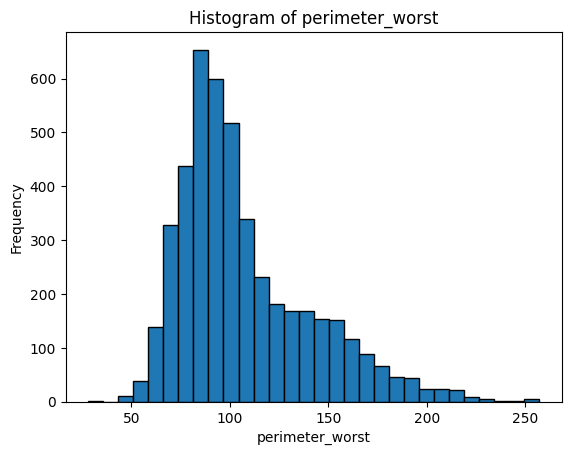

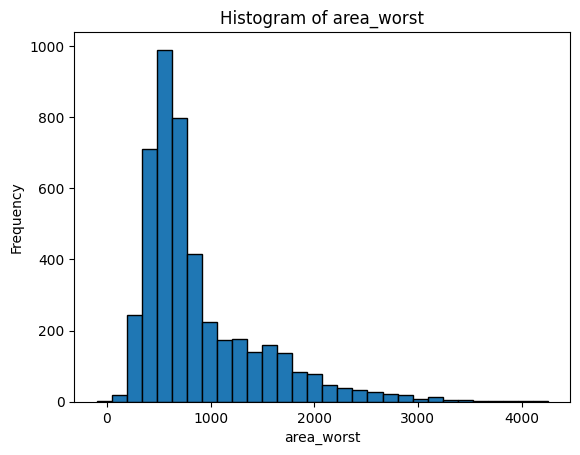

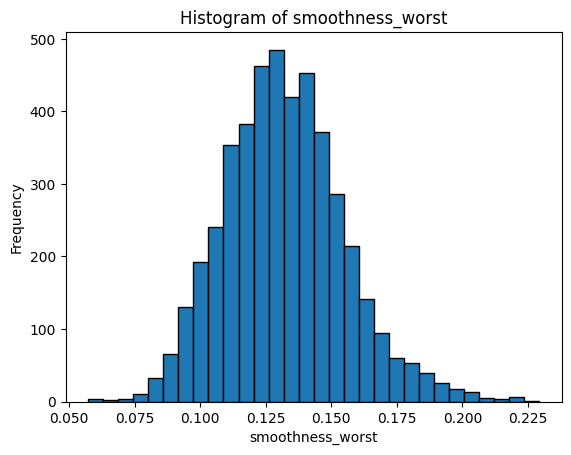

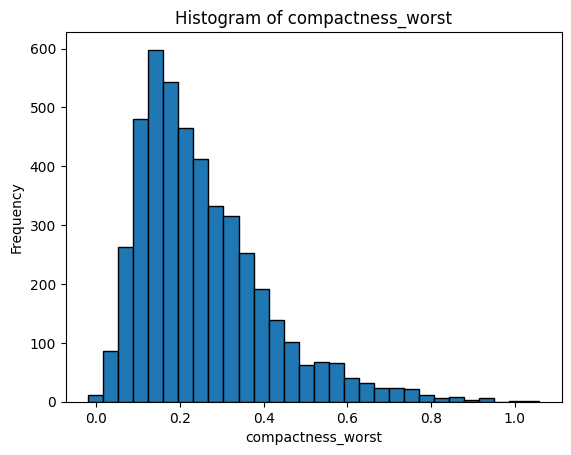

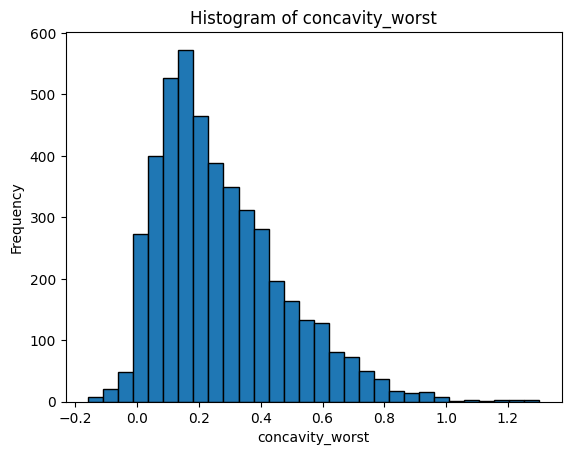

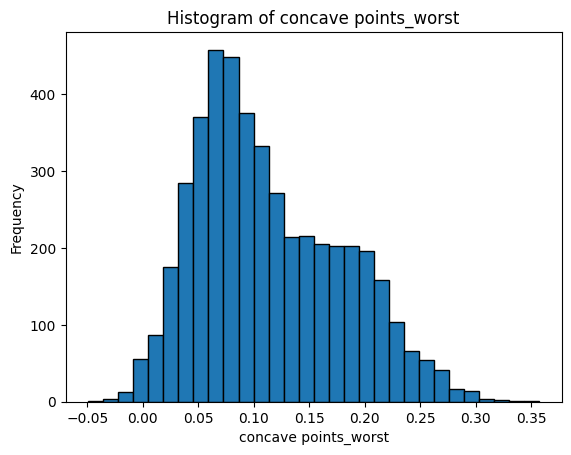

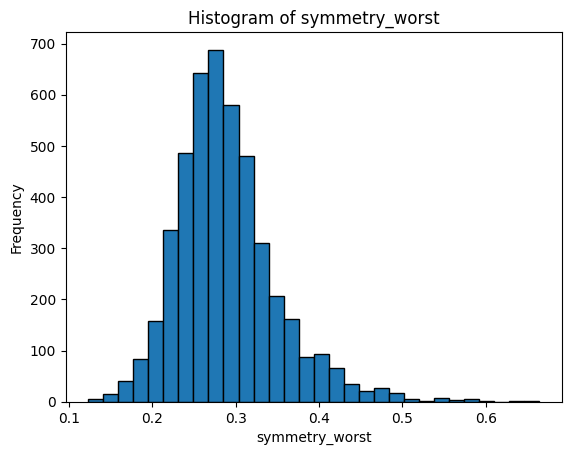

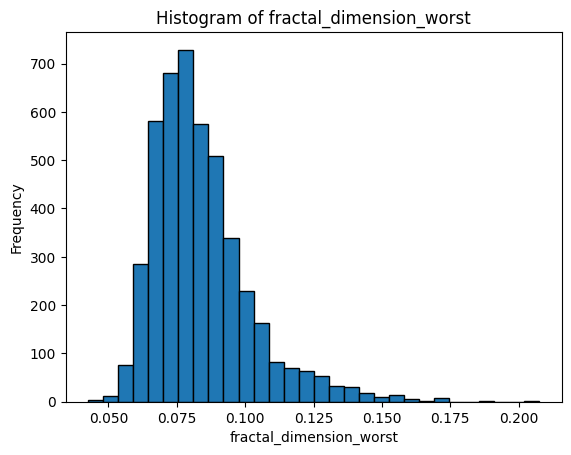

In [12]:
for col in df.select_dtypes(include=['number']).columns:
    plt.figure()
    plt.hist(df[col], bins=30, edgecolor='black')
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

#Barchart

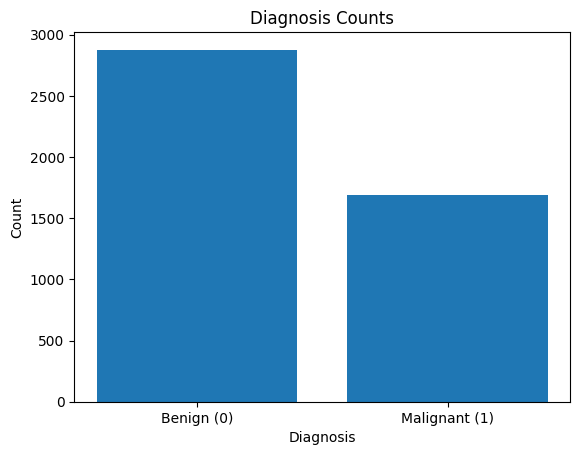

In [13]:
counts = df['diagnosis'].value_counts().sort_index()
labels = ['Benign (0)', 'Malignant (1)']

plt.figure()
plt.bar(labels, counts)
plt.title("Diagnosis Counts")
plt.xlabel("Diagnosis")
plt.ylabel("Count")
plt.show()

#Piechart

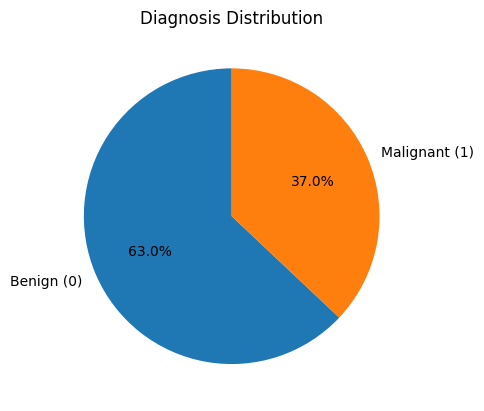

In [14]:
plt.figure()
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title("Diagnosis Distribution")
plt.show()

#Scatter plot

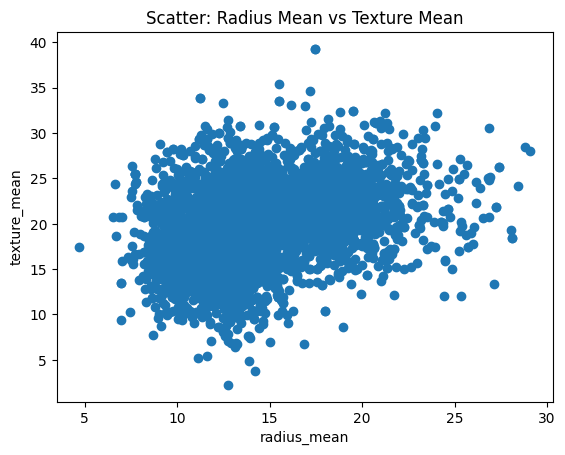

In [15]:
plt.figure()
plt.scatter(df['radius_mean'], df['texture_mean'])
plt.title("Scatter: Radius Mean vs Texture Mean")
plt.xlabel("radius_mean")
plt.ylabel("texture_mean")
plt.show()

#Pair plot

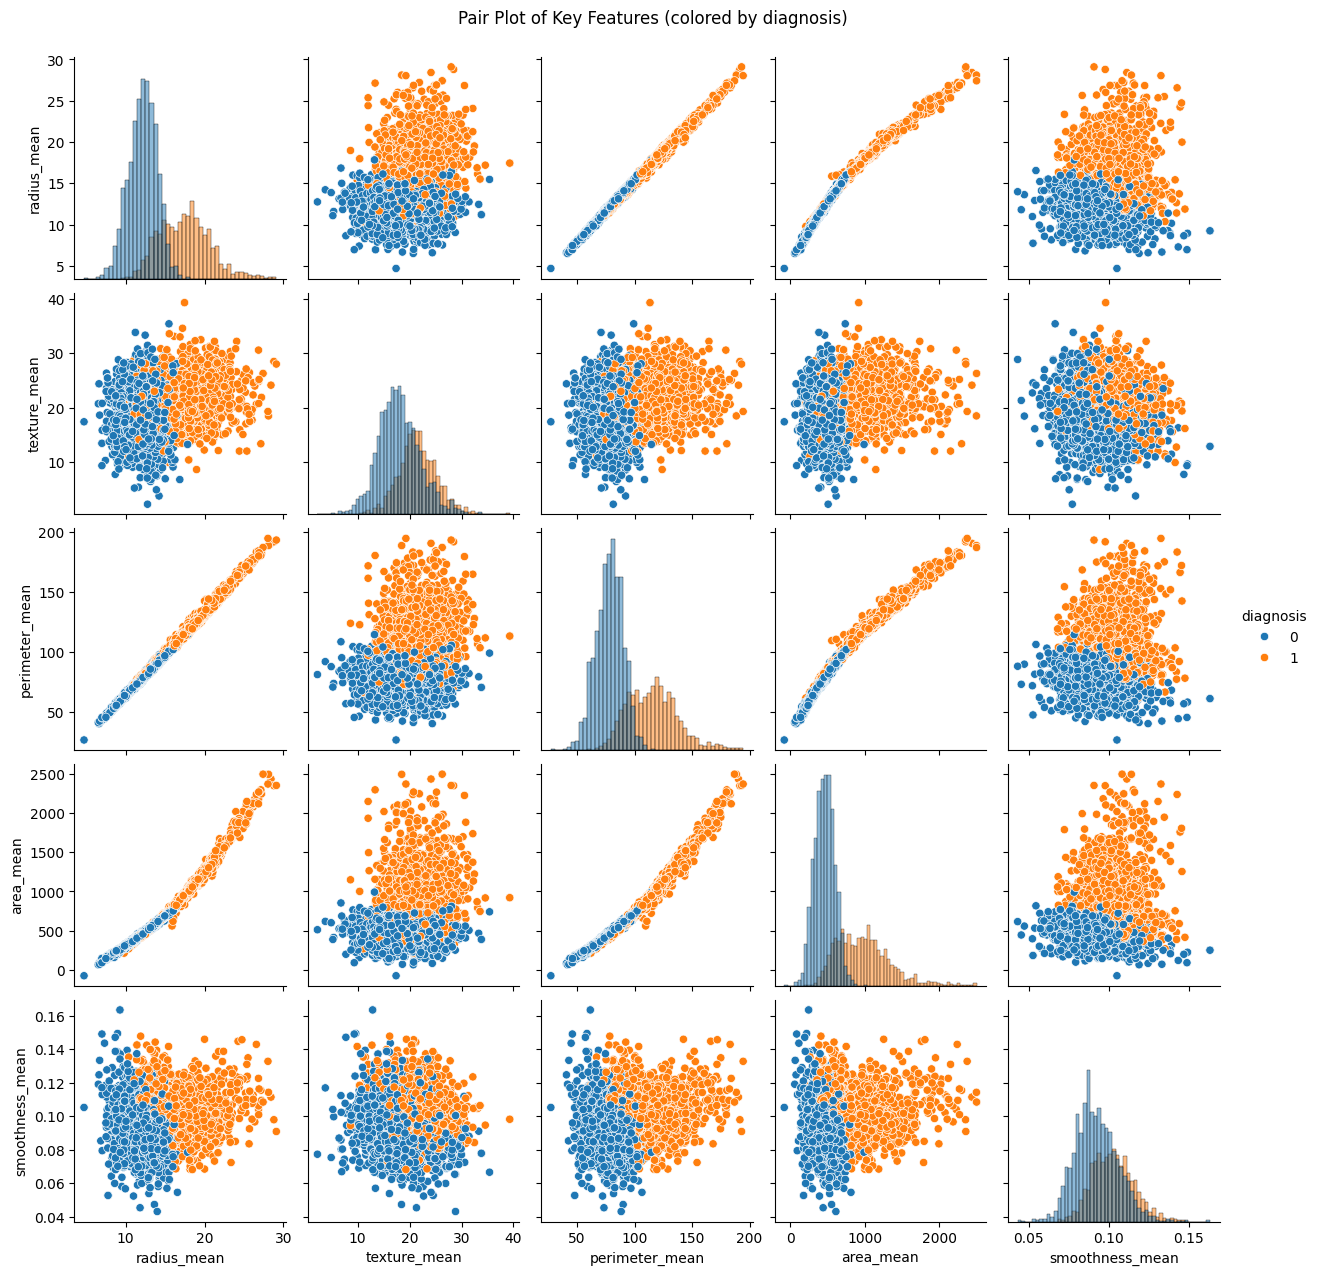

In [16]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
subset = numeric_cols[:6]  # e.g. ['radius_mean', 'texture_mean', ...]

if 'diagnosis' in subset:
    subset.remove('diagnosis')

sns.pairplot(df[subset + ['diagnosis']], hue='diagnosis', diag_kind='hist')
plt.suptitle("Pair Plot of Key Features (colored by diagnosis)", y=1.02)
plt.show()

#Correlation Matrix

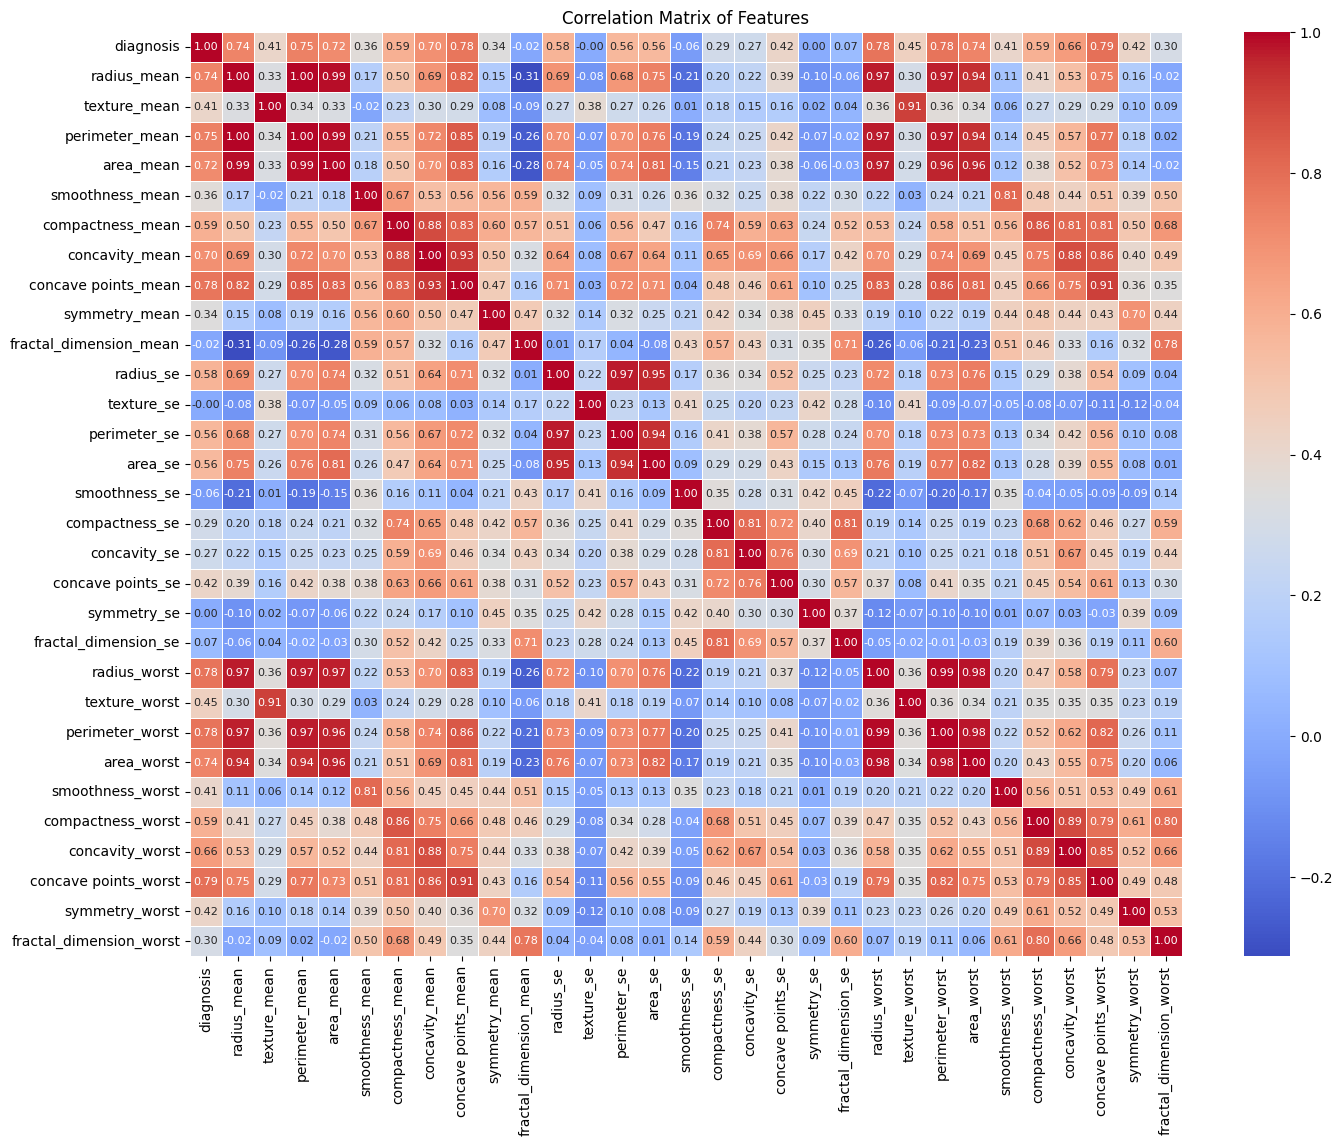

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = df.corr().fillna(0)

corr_matrix = corr_matrix.drop(columns=['Unnamed: 32'], errors='ignore')

plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, annot_kws={"size": 8})


plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Matrix of Features')

plt.show()

#Train-Test Split

In [18]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

#Feature Scaling

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#Logistic Regression

In [20]:
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)

acc_lr = accuracy_score(y_test, y_pred_lr)
prec_lr = precision_score(y_test, y_pred_lr)
rec_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

#Model Evaluation of lr

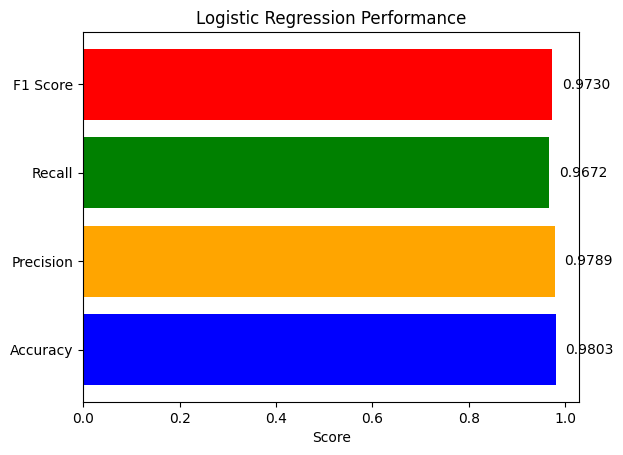

In [21]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_lr, prec_lr, rec_lr, f1_lr]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])

plt.xlabel("Score")
plt.title("Logistic Regression Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')
plt.show()

#KNN Classifier

In [22]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)

acc_knn = accuracy_score(y_test, y_pred_knn)
prec_knn = precision_score(y_test, y_pred_knn)
rec_knn = recall_score(y_test, y_pred_knn)
f1_knn = f1_score(y_test, y_pred_knn)

#KNN Evaluation

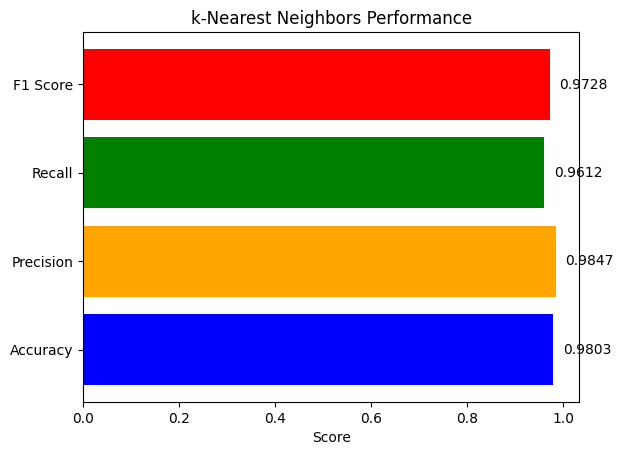

In [23]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_knn, prec_knn, rec_knn, f1_knn]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])

plt.xlabel("Score")
plt.title("k-Nearest Neighbors Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')

plt.show()

#SVM Classifier

In [24]:
svm_model = SVC(random_state=42, probability=True)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)

acc_svm = accuracy_score(y_test, y_pred_svm)
prec_svm = precision_score(y_test, y_pred_svm)
rec_svm = recall_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)

#SVM Evaluation

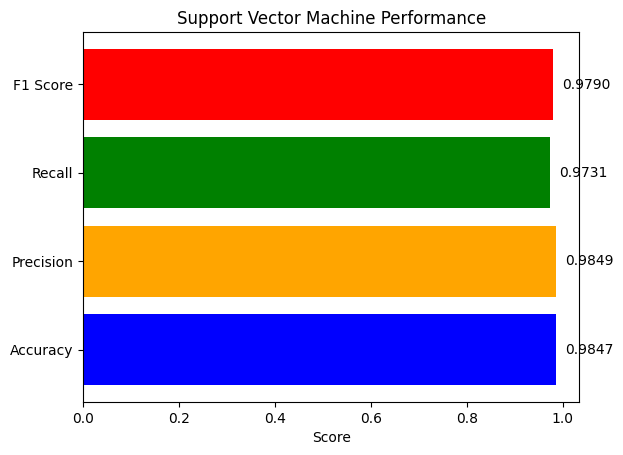

In [25]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_svm, prec_svm, rec_svm, f1_svm]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])

plt.xlabel("Score")
plt.title("Support Vector Machine Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')

plt.show()


#Random Forest Classifier

In [26]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)

acc_rf = accuracy_score(y_test, y_pred_rf)
prec_rf = precision_score(y_test, y_pred_rf)
rec_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

#Random Forest Evaluation

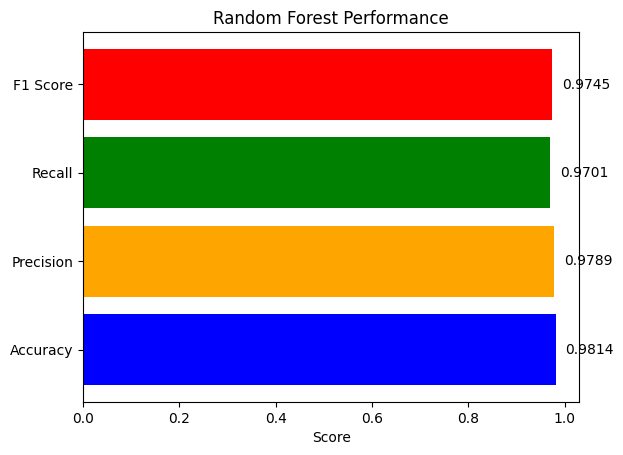

In [27]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_rf, prec_rf, rec_rf, f1_rf]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])

plt.xlabel("Score")
plt.title("Random Forest Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')

plt.show()

#Multi-Layer Perceptron

In [28]:
mlp_model = MLPClassifier(random_state=42, max_iter=1000)
mlp_model.fit(X_train_scaled, y_train)
y_pred_mlp = mlp_model.predict(X_test_scaled)

acc_mlp = accuracy_score(y_test, y_pred_mlp)
prec_mlp = precision_score(y_test, y_pred_mlp)
rec_mlp = recall_score(y_test, y_pred_mlp)
f1_mlp = f1_score(y_test, y_pred_mlp)

#MLP Performance

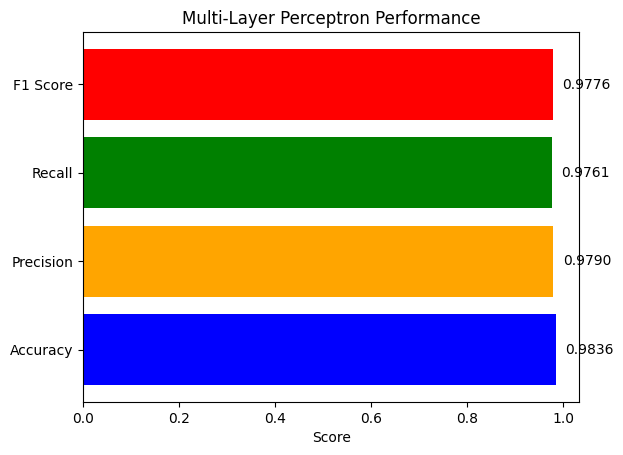

In [29]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_mlp, prec_mlp, rec_mlp, f1_mlp]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Score")
plt.title("Multi-Layer Perceptron Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')

plt.show()

#XGBoost

In [30]:
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='logloss')
xgb_model.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled)

acc_xgb = accuracy_score(y_test, y_pred_xgb)
prec_xgb = precision_score(y_test, y_pred_xgb)
rec_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

#XGBoost Model Evaluation

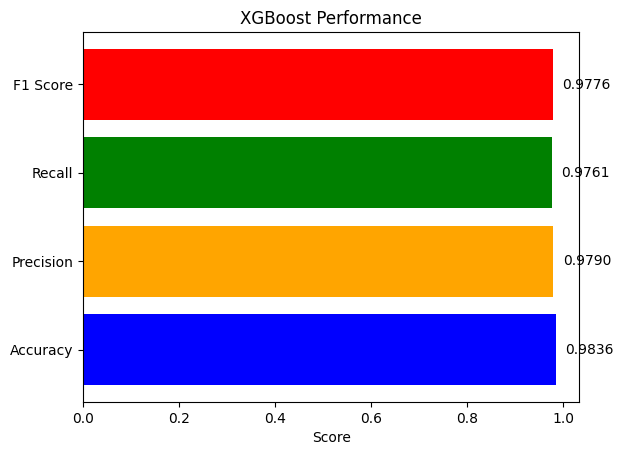

In [31]:
import matplotlib.pyplot as plt

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [acc_xgb, prec_xgb, rec_xgb, f1_xgb]

plt.barh(metrics, values, color=['blue', 'orange', 'green', 'red'])
plt.xlabel("Score")
plt.title("XGBoost Performance")

for index, value in enumerate(values):
    plt.text(value + 0.02, index, f"{value:.4f}", va='center')

plt.show()

#Model Performance Comparison

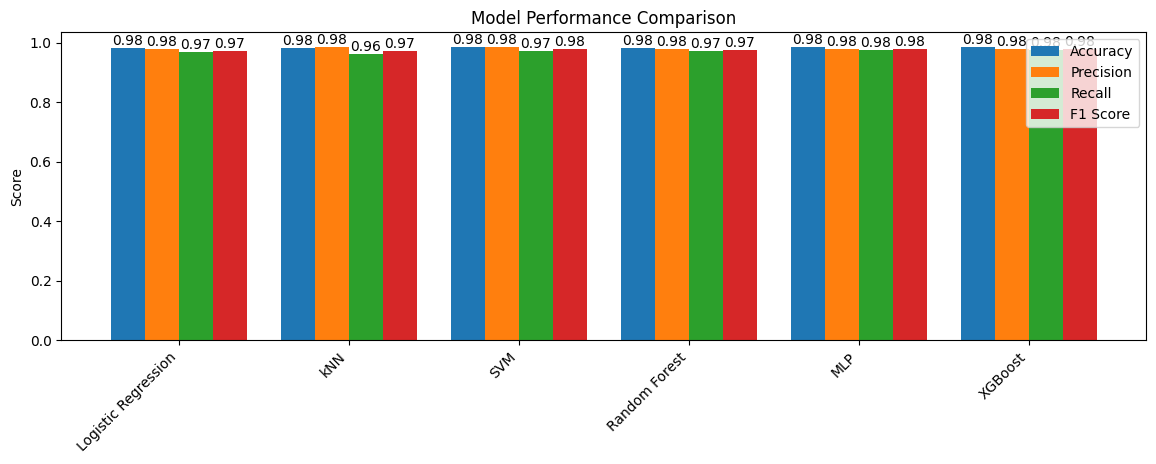

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
results = {
    "Model": ["Logistic Regression", "kNN", "SVM", "Random Forest", "MLP", "XGBoost"],
    "Accuracy": [acc_lr, acc_knn, acc_svm, acc_rf, acc_mlp, acc_xgb],
    "Precision": [prec_lr, prec_knn, prec_svm, prec_rf, prec_mlp, prec_xgb],
    "Recall": [rec_lr, rec_knn, rec_svm, rec_rf, rec_mlp, rec_xgb],
    "F1 Score": [f1_lr, f1_knn, f1_svm, f1_rf, f1_mlp, f1_xgb]
}
results_df = pd.DataFrame(results)

metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
x = np.arange(len(results_df["Model"]))
width = 0.2

fig, ax = plt.subplots(figsize=(14, 4))

for i, metric in enumerate(metrics):
    ax.bar(x + i * width, results_df[metric], width, label=metric)

ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
ax.set_xticklabels(results_df["Model"], rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.legend()

for i, metric in enumerate(metrics):
    for j, value in enumerate(results_df[metric]):
        ax.text(j + i * width, value + 0.01, f"{value:.2f}", ha='center', fontsize=10)

plt.show()

#Test Accuracy Comparison

C:\Users\LTC\AppData\Local\Temp\ipykernel_1240\807366165.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis") # Changed y to 'Accuracy'


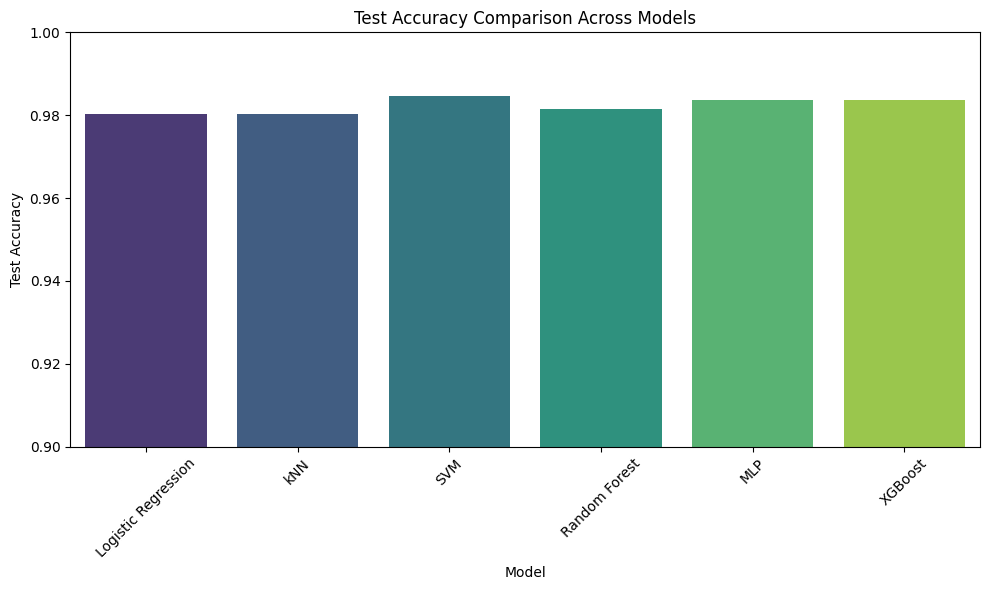

In [33]:
plt.figure(figsize=(10, 6))
sns.barplot(x="Model", y="Accuracy", data=results_df, palette="viridis") # Changed y to 'Accuracy'
plt.title("Test Accuracy Comparison Across Models")
plt.ylabel("Test Accuracy")
plt.xlabel("Model")
plt.ylim(0.90, 1.00)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pickle
model_scores = {
    'LogisticRegression': acc_lr,
    'KNN': acc_knn,
    'SVM': acc_svm,
    'RandomForest': acc_rf,
    'MLP': acc_mlp,
    'XGBoost': acc_xgb
}

best_name = max(model_scores, key=model_scores.get)
best_model = {
    'LogisticRegression': lr_model,
    'KNN': knn_model,
    'SVM': svm_model,
    'RandomForest': rf_model,
    'MLP': mlp_model,
    'XGBoost': xgb_model
}[best_name]

print(f"Best performing model: {best_name} with accuracy = {model_scores[best_name]:.4f}")

with open('best_model.pkl', 'wb') as f:
    pickle.dump({'model': best_model, 'scaler': scaler}, f)
print("Saved best_model.pkl")

Best performing model: SVM with accuracy = 0.9847
Saved best_model.pkl
